# Introduction

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow.  Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

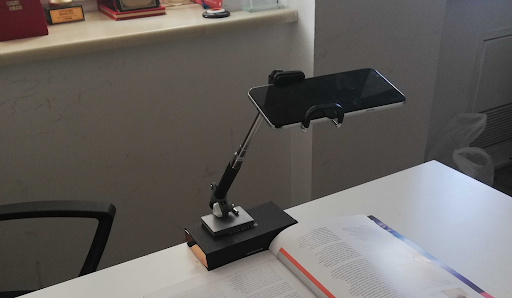


Data Description:

Images of the book are labeled in folders as Flip and Not Flip

Goal:

Predict if the page is being flipped using a single image.

Install Tensorflow and required libraries

In [ ]:
%%capture
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image
import matplotlib.pyplot as plt
import os
import zipfile
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#### Data Interpretation

Read the file from Google Drive, unzip and create folders

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls /content/gdrive/MyDrive/colab

images.zip  monreader0507.ipynb  monreader59-main.ipynb


In [ ]:
%%capture
!unzip gdrive/MyDrive/colab/images.zip

In [ ]:
# Shows the sub-folders for training
!ls images/training

a_notflip  b_flip  flip  notflip


Rename the sub-folders so that they will be sequential
a_notflip  0
b_flip 1

In [ ]:
! mv images/training/notflip images/training/a_notflip

In [ ]:
! mv images/training/flip images/training/b_flip

In [ ]:
!ls images/training

a_notflip  b_flip


In [ ]:
xdir=os.listdir("images/training")
xdir

['a_notflip', 'b_flip']

Check the number of images for each class of Training set

In [ ]:
print("Number of images in training for",os.listdir('images/training')[0] ,"class",len(os.listdir('images/training/'+os.listdir('images/training')[0])))
print("Number of images in training for",os.listdir('images/training')[1] ,"class",len(os.listdir('images/training/'+os.listdir('images/training')[1])))

Number of images in training for a_notflip class 1231
Number of images in training for b_flip class 1163


Display a few images from the training folder

Displaying images from Flip folder
 
images/training/b_flip/0039_000000023.jpg 

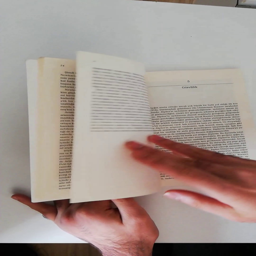

images/training/b_flip/0015_000000014.jpg 

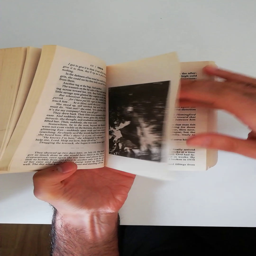

images/training/b_flip/0056_000000024.jpg 

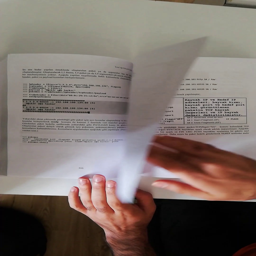

images/training/b_flip/0036_000000018.jpg 

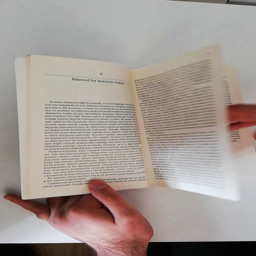

images/training/b_flip/0006_000000023.jpg 

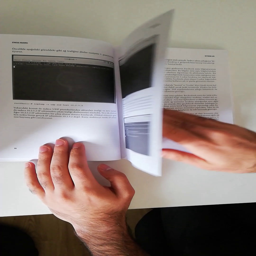

Displaying images from Flip folder
 


In [ ]:
img_dir="images/training/b_flip"
i = 0
source=os.listdir(img_dir)
print("Displaying images from Flip folder")
print(" ")
while i < 5:
        fname=os.path.join(img_dir,source[i])
        im=Image.open(fname)
        print(fname, end=' ')
        display(im.resize((256,256)))
        i=i+1
print("Displaying images from Flip folder")
print(" ")

Displaying images from Not Flip folder
 
images/training/a_notflip/0048_000000004.jpg 

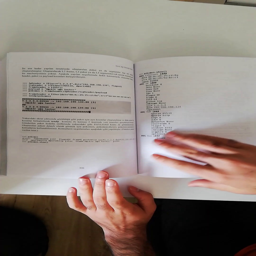

images/training/a_notflip/0039_000000023.jpg 

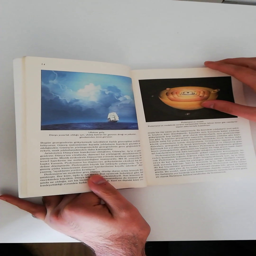

images/training/a_notflip/0054_000000006.jpg 

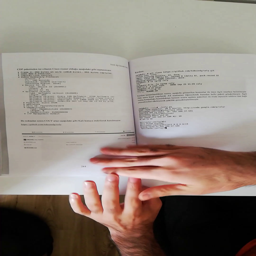

images/training/a_notflip/0015_000000014.jpg 

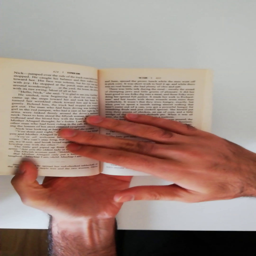

images/training/a_notflip/0001_000000027.jpg 

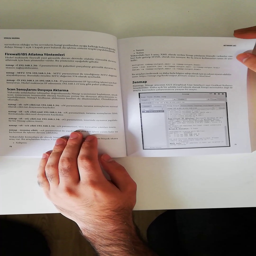

Displaying images from Not Flip folder


In [ ]:
img_dir="images/training/a_notflip"
i = 0
source=os.listdir(img_dir)
print("Displaying images from Not Flip folder")
print(" ")
while i < 5:
        fname=os.path.join(img_dir,source[i])
        im=Image.open(fname)
        print(fname, end=' ')
        display(im.resize((256,256)))
        i=i+1
print("Displaying images from Not Flip folder")

Read the images from the training folder. The images are split into training and validaiton set

In [ ]:
from keras.preprocessing import image_dataset_from_directory
path ="images/training"
path

'images/training'

#### Data Pre-processing

In [ ]:
img_height=128
img_width=128

In [ ]:
train_ds=image_dataset_from_directory(path, labels="inferred", label_mode='binary',validation_split=0.2,subset='training',shuffle=True, seed=42,image_size=(img_height,img_width),batch_size=32)

Found 4784 files belonging to 2 classes.
Using 3828 files for training.


In [ ]:
val_ds=image_dataset_from_directory(path,labels="inferred",label_mode='binary',validation_split=0.2,shuffle=True,subset='validation',seed=42,image_size=(img_height,img_width),batch_size=32)

Found 4784 files belonging to 2 classes.
Using 956 files for validation.


Display the Class Names of the Training data.

In [ ]:
class_names=train_ds.class_names
class_names


['a_notflip', 'b_flip']

Display few images and labels from the train dataset, we display images from batch 2

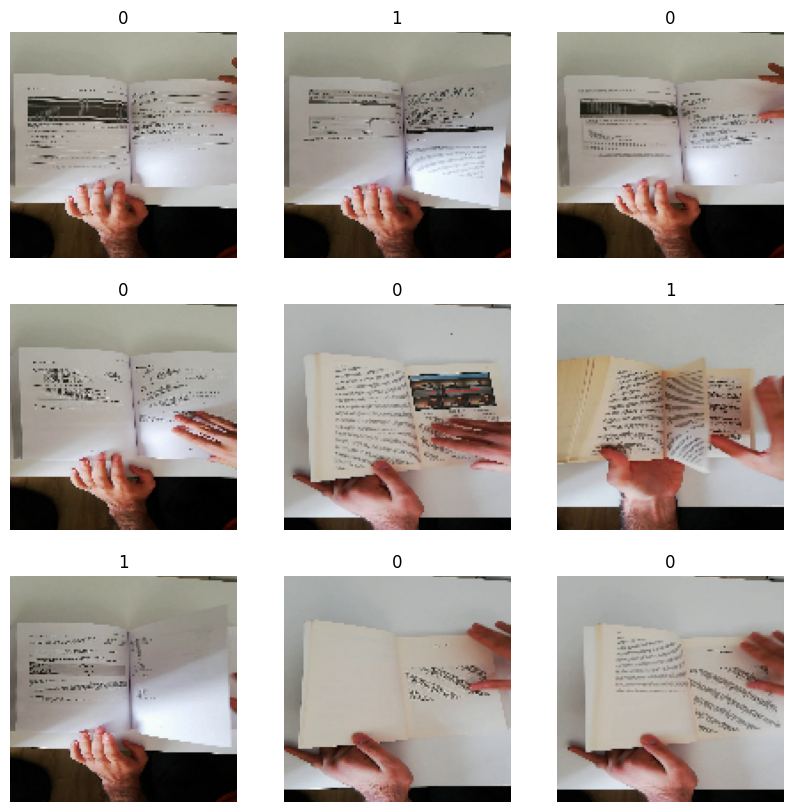

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(int(labels[i])))
    plt.axis("off")




#### Model Development

In [ ]:
from keras.layers import Resizing
from keras.layers import Rescaling
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height,img_width, 3)),
      tf.keras.layers.Conv2D(64,(5,5),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128,activation='relu'),
      layers.Dense(1,activation="sigmoid")
])

Compile using loss function Binary Crossentropy and get the metrics

In [ ]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'),
]

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="binary_crossentropy",
              metrics= metrics)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 124, 124, 64)      4864      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 62, 62, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                

Define the callback function

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
        # Check after epoch end
        def on_epoch_end(self,epoch,logs={}):
            if logs.get('accuracy') is not None and logs.get('accuracy') > 0.98:
                print("\nStopped as desried Training Accuracy reached")
                # Stop when accuracy is reached
                self.model.stop_training = True
callback =myCallback()



### Model Training

In [ ]:
ep = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = ep,
    callbacks=callback,
    batch_size = 64
    )

Epoch 1/40
120/120 [==============================] - 37s 295ms/step - loss: 0.7658 - accuracy: 0.5598 - precision: 0.5735 - recall: 0.3402 - auc: 0.5748 - prc: 0.5507 - val_loss: 0.6558 - val_accuracy: 0.6192 - val_precision: 0.5928 - val_recall: 0.7615 - val_auc: 0.7042 - val_prc: 0.7295
Epoch 2/40
120/120 [==============================] - 35s 294ms/step - loss: 0.5921 - accuracy: 0.6661 - precision: 0.7011 - recall: 0.5363 - auc: 0.7282 - prc: 0.7410 - val_loss: 0.4527 - val_accuracy: 0.7929 - val_precision: 0.7236 - val_recall: 0.9477 - val_auc: 0.9197 - val_prc: 0.9214
Epoch 3/40
120/120 [==============================] - 35s 294ms/step - loss: 0.3766 - accuracy: 0.8273 - precision: 0.8395 - recall: 0.7936 - auc: 0.9121 - prc: 0.9119 - val_loss: 0.2242 - val_accuracy: 0.9268 - val_precision: 0.9130 - val_recall: 0.9435 - val_auc: 0.9783 - val_prc: 0.9784
Epoch 4/40
120/120 [==============================] - 35s 293ms/step - loss: 0.2516 - accuracy: 0.8932 - precision: 0.9003 - re

Display the metrics for the model

In [ ]:
history.history


{'loss': [0.7658106684684753,
  0.5920885801315308,
  0.37659645080566406,
  0.25162482261657715,
  0.17473706603050232,
  0.14534738659858704,
  0.09238635748624802,
  0.08558502793312073,
  0.06773059070110321,
  0.07082054764032364,
  0.052000466734170914],
 'accuracy': [0.5598223805427551,
  0.6661441922187805,
  0.8273249864578247,
  0.8931556940078735,
  0.9299895763397217,
  0.940700113773346,
  0.9636886119842529,
  0.9691745042800903,
  0.9736154675483704,
  0.9741379022598267,
  0.9804075360298157],
 'precision': [0.5735160112380981,
  0.701133131980896,
  0.8395415544509888,
  0.9002785682678223,
  0.932092010974884,
  0.9406641125679016,
  0.9666484594345093,
  0.9685466289520264,
  0.9775588512420654,
  0.9734417200088501,
  0.9768443703651428],
 'recall': [0.34019502997398376,
  0.53629469871521,
  0.793607771396637,
  0.8754062652587891,
  0.9219934940338135,
  0.9360780119895935,
  0.9577465057373047,
  0.9674972891807556,
  0.9674972891807556,
  0.9729143977165222,
  0

Calculate the F1 score for each epoch using the precision and recall for each epoch

In [ ]:
i=0
j=0
f1=[]
for i,j in zip(history.history['precision'],history.history['recall']):
  if i != 0 or j != 0:
      f=2 * (i * j) / (i + j)
  else:
      f=0.0
  f1.append(f)
history.history['f1']=f1

l=0
m=0
vf1=[]
for l,m in zip(history.history['val_precision'],history.history['val_recall']):
    if l != 0 or m != 0:
        vf=2 * (l * m) / (l + m)
    else:
        vf=0.0
    vf1.append(vf)
history.history['val_f1']=vf1

In [ ]:
history.history['f1']

[0.4270656429299248,
 0.6077348067457352,
 0.81592869859211,
 0.8876682215893388,
 0.9270152510638452,
 0.9383654588667926,
 0.9621768930548956,
 0.9680216746942377,
 0.972502046532965,
 0.9731779874295097,
 0.9797461598986343]

Plots for Accuracy , Loss , Precison , Recall , F1 Score , AUC. Plots shows the metrics against epochs

Text(0.5, 1.0, 'Training and Validation AUC')

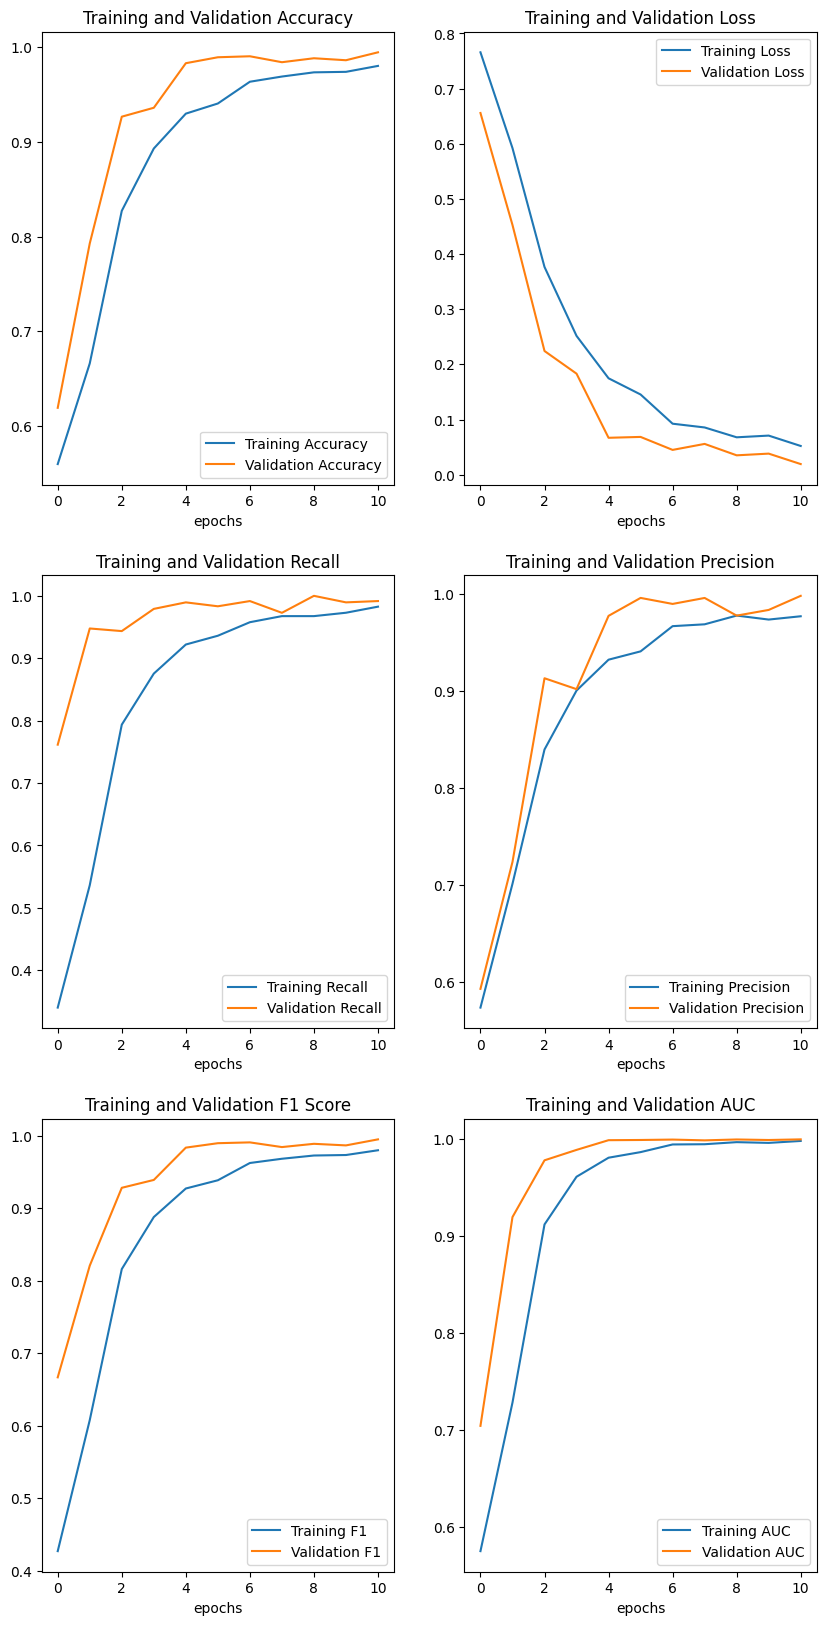

In [ ]:

# Display the plots showing the metrics vs epochs
f1=history.history['f1']
val_f1= history.history['val_f1']
loss=history.history['loss']
val_loss= history.history['val_loss']
recall=history.history['recall']
val_recall= history.history['val_recall']
precision=history.history['precision']
val_precision= history.history['val_precision']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
auc=history.history['auc']
val_auc=history.history['val_auc']

epoch = range(len(f1))
plt.figure(figsize=(10,20))

plt.subplot(3,2,1)
plt.plot(epoch,acc,label='Training Accuracy')
plt.plot(epoch,val_acc,label='Validation Accuracy')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation Accuracy")

plt.subplot(3,2,2)
plt.plot(epoch,loss,label='Training Loss')
plt.plot(epoch,val_loss,label='Validation Loss')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(3,2,3)
plt.plot(epoch,recall,label='Training Recall')
plt.plot(epoch,val_recall,label='Validation Recall')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation Recall")

plt.subplot(3,2,4)
plt.plot(epoch,precision,label='Training Precision')
plt.plot(epoch,val_precision,label='Validation Precision')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation Precision")

plt.subplot(3,2,5)
plt.plot(epoch,f1,label='Training F1')
plt.plot(epoch,val_f1,label='Validation F1')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation F1 Score")

plt.subplot(3,2,6)
plt.plot(epoch,auc,label='Training AUC')
plt.plot(epoch,val_auc,label='Validation AUC')
plt.xlabel("epochs")
plt.legend()
plt.title("Training and Validation AUC")

### Training Metrics evaluation

In [ ]:
train_images=[]
train_labels=[]
for batch in train_ds:
    images, labels = batch
    train_images.append(images)
    train_labels.append(labels)


In [ ]:
train_images = np.concatenate(train_images , axis = 0)
train_labels = np.concatenate(train_labels , axis = 0)

In [ ]:
model.evaluate(train_images, train_labels)
train_pred = model.predict(train_images)

120/120 [==============================] - 6s 52ms/step


[[1975    7]
 [   2 1844]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1982
         1.0       1.00      1.00      1.00      1846

    accuracy                           1.00      3828
   macro avg       1.00      1.00      1.00      3828
weighted avg       1.00      1.00      1.00      3828

ROC Score 0.9976923951533465


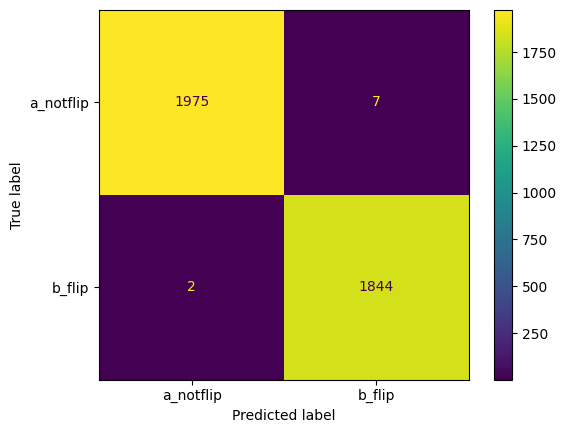

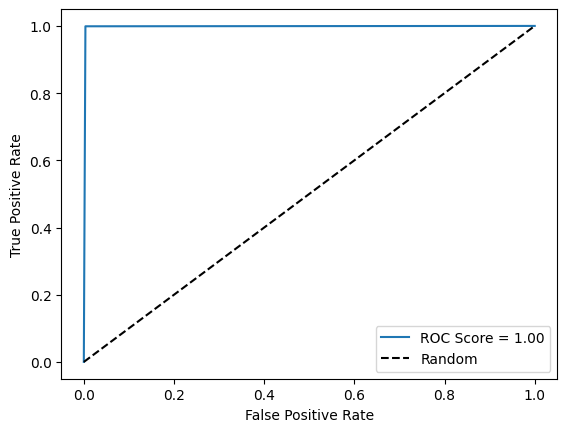

In [ ]:
cm_train = confusion_matrix(train_labels, np.round(train_pred))
print(cm_train)
from sklearn.metrics import classification_report
print(classification_report(train_labels,np.round(train_pred)))
cm_train_plot=ConfusionMatrixDisplay(cm_train,display_labels=class_names)
cm_train_plot.plot()

from sklearn.metrics import roc_auc_score,roc_curve
roc_auc=roc_auc_score(train_labels,np.round(train_pred))
print("ROC Score",roc_auc)
fpr,tpr,threshold = roc_curve(train_labels,np.round(train_pred))
plt.figure()
plt.plot(fpr,tpr,label='ROC Score = %0.2f' % roc_auc)
plt.plot((0,1),(0,1),"--",color='black',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

#### Model prediction on the test images dataset

Rename the test directory and read the images from the test directory

In [ ]:
! mv images/testing/notflip images/testing/a_notflip
! mv images/testing/flip images/testing/b_flip

mv: cannot stat 'images/testing/notflip': No such file or directory
mv: cannot stat 'images/testing/flip': No such file or directory


In [ ]:
test_path ="images/testing"
test_path
test_ds=image_dataset_from_directory(test_path,labels="inferred",label_mode='binary',shuffle=True,image_size=(img_height,img_width),batch_size=597)

Found 1194 files belonging to 2 classes.


In [ ]:
test_images, test_labels = next(iter(test_ds))
model.evaluate(test_images, test_labels)
pred = model.predict(test_images)
from sklearn.metrics import classification_report
print(classification_report(test_labels,np.round(pred)))

19/19 [==============================] - 1s 57ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       305
         1.0       0.99      0.99      0.99       292

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



In [ ]:
cm_test = confusion_matrix(test_labels, np.round(pred))
print(cm_test)
from sklearn.metrics import classification_report
print(classification_report(test_labels,np.round(pred)))

[[301   4]
 [  3 289]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       305
         1.0       0.99      0.99      0.99       292

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



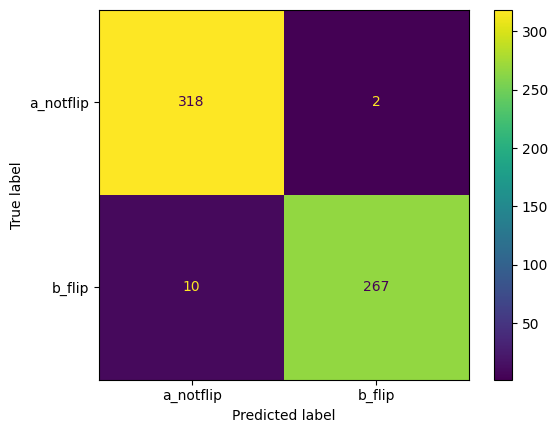

In [ ]:
cm_test_plot=ConfusionMatrixDisplay(cm_test,display_labels=class_names)
cm_test_plot.plot()

ROC Score 0.9883056366494498


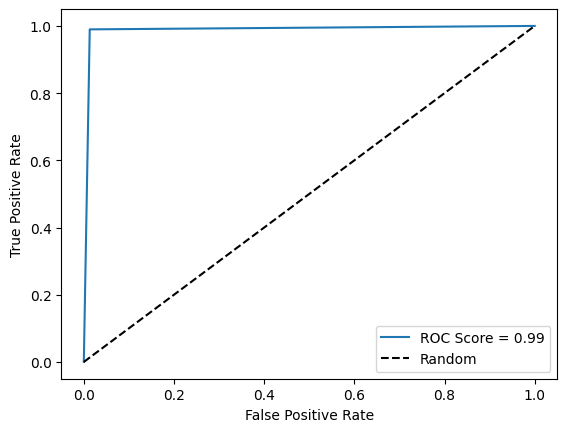

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve
roc_auc=roc_auc_score(test_labels,np.round(pred))
print("ROC Score",roc_auc)
fpr,tpr,threshold = roc_curve(test_labels,np.round(pred))
plt.figure()
plt.plot(fpr,tpr,label='ROC Score = %0.2f' % roc_auc)
plt.plot((0,1),(0,1),"--",color='black',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Model testing using random images from the test data set

Testing the model for images from b_flip

Test image path images/testing/b_flip/0007_000000024.jpg
Test image 



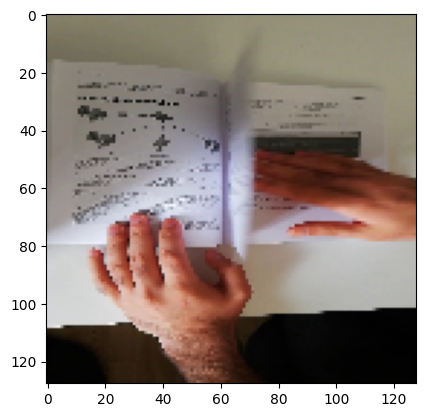

1/1 [==============================] - 0s 32ms/step
Model Prediction: Image is Flipped

Test image path images/testing/b_flip/0018_000000004.jpg
Test image 



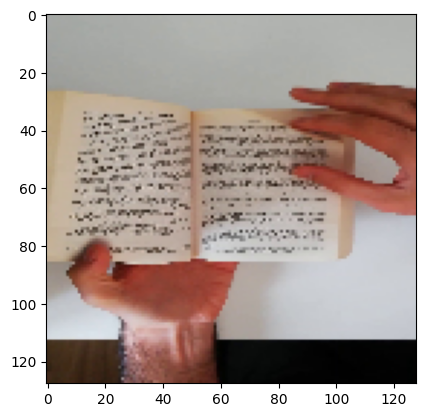

1/1 [==============================] - 0s 30ms/step
Model Prediction: Image is Not Flipped

Test image path images/testing/b_flip/0006_000000024.jpg
Test image 



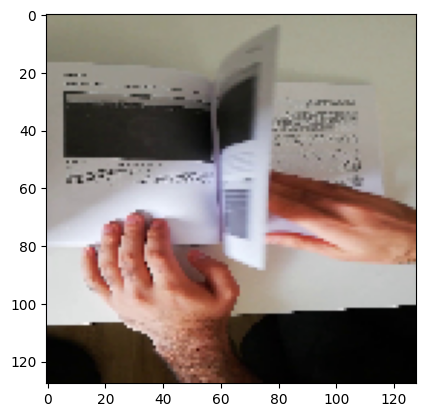

1/1 [==============================] - 0s 31ms/step
Model Prediction: Image is Flipped

Test image path images/testing/b_flip/0017_000000015.jpg
Test image 



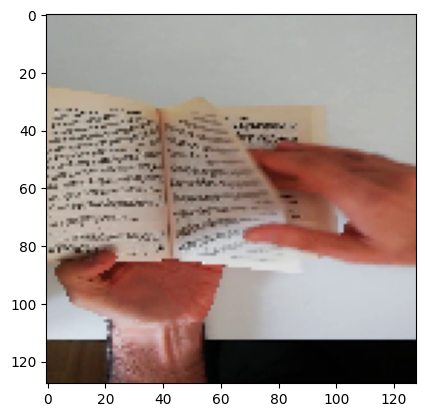

1/1 [==============================] - 0s 31ms/step
Model Prediction: Image is Flipped

Test image path images/testing/b_flip/0040_000000024.jpg
Test image 



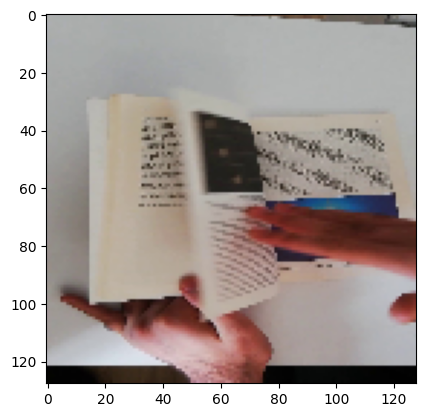

1/1 [==============================] - 0s 31ms/step
Model Prediction: Image is Flipped



In [ ]:
import numpy as np
def test_model(test):
  testdir='images/testing/'+ test
  dirlist=os.listdir(testdir)
  print("Testing the model for images from " + test )
  print("")
  for i in range(5):
    print("Test image path",os.path.join(testdir,dirlist[i]))
    print("Test image ")
    print("")
    fname = testdir + '/'+ dirlist[i]
    im=tf.keras.utils.load_img(fname, target_size=(128,128))
    plt.imshow(im)
    plt.show()
    img=tf.keras.utils.img_to_array(im)
    img=img/255
    testimg = np.expand_dims(img, axis=0)
    pred=model.predict(testimg,batch_size=10)
    predictions = tf.where(pred[0] < 0.5,0, 1)
    if predictions == 0:
        print("Model Prediction: Image is Not Flipped")
        print("")
    elif predictions == 1:
        print("Model Prediction: Image is Flipped")
        print("")

test_model('b_flip')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model.save('/content/gdrive/MyDrive/monreader.keras')
!ls


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
drive  gdrive  images  sample_data


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)
